In [28]:
import os
import pandas as pd
import numpy as np


import numpy as np



def abs_metric2(acc, cost, sc_acc, sc_cost=40):
    # Normalize the cost to be between 0 and 1
    acc_factor = 1 if acc>=sc_acc else (acc-sc_acc)/sc_acc
    cost_factor = (sc_cost-cost)/sc_cost
    return 0.5*acc_factor+0.5*cost_factor

def abs_metric1(acc, cost, sc_acc, sc_cost=40, direct_acc=None, direct_cost=1):
    if direct_acc is None:
        direct_acc = sc_acc

    # Normalize the accuracy to be between 0 and 1
    if acc >= sc_acc:
        acc_factor = 1
    elif acc <= direct_acc:
        acc_factor = 0
    else:
        acc_factor = (acc - direct_acc) / (sc_acc - direct_acc)

    # Normalize the cost to be between 0 and 1
    if cost <= direct_cost:
        cost_factor = 1
    elif cost >= sc_cost:
        cost_factor = 0
    else:
        cost_factor = (sc_cost - cost) / (sc_cost - direct_cost)

    # Calculate the weighted average of acc_factor and cost_factor
    metric = 0.5 * acc_factor + 0.5 * cost_factor

    return metric


# Example usage
acc = 0.9
cost = 20
SC_acc = 0.8
print(abs_metric2(acc, cost, SC_acc))  # Example output




# Directory containing the CSV files
directory = "../../result/experiments_output/test_N_threshold"

# Initialize variables
max_cs_accuracy = 0
min_steps = float('inf')
min_cs_accuracy_greater_than_sc = float('inf')
max_cs_acc_with_step_constraints = 0
max_abs_metric = 0

df_max_cs_accuracy = None
df_min_steps = None
df_min_cs_accuracy_greater_than_sc = None
df_max_cs_acc_with_step_constraints = None
df_max_abs_metric = None

max_cs_accuracy_N = None
max_cs_accuracy_threshold = None
min_steps_N = None
min_steps_threshold = None
min_cs_accuracy_greater_than_sc_N = None
min_cs_accuracy_greater_than_sc_threshold = None
max_cs_acc_with_step_constraints_N = None
max_cs_acc_with_step_constraints_threshold = None
max_abs_metric_N = None
max_abs_metric_threshold = None

# List all files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        df['direct_acc'] = df['Correctness'].apply(lambda x: eval(x)[0])

# Calculate the mean of 'direct_acc' and assign it to a new variable 'direct_acc_mean'
        direct_acc_mean = df['direct_acc'].mean()

        # Extract N and threshold from the filename
        parts = filename.split("_")
        N = int(parts[4][0])
        threshold = float(parts[2])
        if(N <= 2):
            continue
        # Calculate CS accuracy, steps, and SC accuracy for the current DataFrame
        cs_accuracy = df['CS_correctness'].mean()
        steps = df['CS_steps'].mean()
        sc_accuracy = df['SC_correctness'].mean()
        es_avg_steps = df['ES_steps'].mean()
        asc_avg_steps = df['asc_steps'].mean()
        
        # Check for the best CS accuracy
        if cs_accuracy > max_cs_accuracy:
            max_cs_accuracy = cs_accuracy
            df_max_cs_accuracy = df
            max_cs_accuracy_N = N
            max_cs_accuracy_threshold = threshold
        
        # Check for the least number of steps
        if steps < min_steps:
            min_steps = steps
            df_min_steps = df
            min_steps_N = N
            min_steps_threshold = threshold
        
        # Check for the CS accuracy greater than SC with the least difference
        if cs_accuracy > sc_accuracy and cs_accuracy - sc_accuracy < min_cs_accuracy_greater_than_sc:
            min_cs_accuracy_greater_than_sc = cs_accuracy - sc_accuracy
            df_min_cs_accuracy_greater_than_sc = df
            min_cs_accuracy_greater_than_sc_N = N
            min_cs_accuracy_greater_than_sc_threshold = threshold
        
        # Check for CS accuracy with step constraints
        if steps < es_avg_steps and steps < asc_avg_steps:
            if cs_accuracy > max_cs_acc_with_step_constraints:
                max_cs_acc_with_step_constraints = cs_accuracy
                df_max_cs_acc_with_step_constraints = df
                max_cs_acc_with_step_constraints_N = N
                max_cs_acc_with_step_constraints_threshold = threshold
        
        # Check for the best abs_metric2_beta
        abs_metric = abs_metric1(cs_accuracy, steps, sc_acc = sc_accuracy,direct_acc = direct_acc_mean)
        if abs_metric > max_abs_metric:
            max_abs_metric = abs_metric
            df_max_abs_metric = df
            max_abs_metric_N = N
            max_abs_metric_threshold = threshold

print("DataFrame with the best CS accuracy:")
print(f"N: {max_cs_accuracy_N}, Threshold: {max_cs_accuracy_threshold}")

print("\nDataFrame with the least number of steps:")
print(f"N: {min_steps_N}, Threshold: {min_steps_threshold}")

print("\nDataFrame with CS accuracy greater than SC and the least difference:")
print(f"N: {min_cs_accuracy_greater_than_sc_N}, Threshold: {min_cs_accuracy_greater_than_sc_threshold}")

print("\nDataFrame with CS accuracy and step constraints:")
print(f"N: {max_cs_acc_with_step_constraints_N}, Threshold: {max_cs_acc_with_step_constraints_threshold}")

print("\nDataFrame with the best abs_metric2_beta:")
print(f"N: {max_abs_metric_N}, Threshold: {max_abs_metric_threshold}")

0.75
DataFrame with the best CS accuracy:
N: 9, Threshold: 0.1

DataFrame with the least number of steps:
N: 3, Threshold: 0.1

DataFrame with CS accuracy greater than SC and the least difference:
N: 8, Threshold: 0.6

DataFrame with CS accuracy and step constraints:
N: 8, Threshold: 0.1

DataFrame with the best abs_metric2_beta:
N: 3, Threshold: 0.1


## Pick N and Main Results (full features)

In [29]:
# Initialize variables
best_df_dict = {}
best_df_list = []

# List all files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        
        # Combine "BigBench_easy" and "BigBench_hard" into "BigBench"
        df['Name'] = df['Name'].replace({"BigBench_easy": "BigBench", "BigBench_hard": "BigBench"})
        
        # Extract N and threshold from the filename
        parts = filename.split("_")
        N = int(parts[4][0])
        threshold = float(parts[2])
        
        # Get unique combinations of Name and Model
        name_model_combinations = df[['Name', 'Model']].drop_duplicates()
        
        for _, row in name_model_combinations.iterrows():
            name = row['Name']
            model = row['Model']
            
            # Filter the DataFrame for the current Name and Model
            df_filtered = df[(df['Name'] == name) & (df['Model'] == model)]
            
            # Calculate CS accuracy, SC accuracy, and average steps for the current DataFrame
            cs_accuracy = df_filtered['CS_correctness'].mean()
            sc_accuracy = df_filtered['SC_correctness'].mean()
            avg_steps = df_filtered['CS_steps'].mean()
            
            es_accuracy = df_filtered['ES_correctness'].mean()
            es_steps = df_filtered['ES_steps'].mean()
            asc_accuracy = df_filtered['asc_correctness'].mean()
            asc_steps = df_filtered['asc_steps'].mean()
            
            key = (name, model)
            
            # Calculate the abs_metric2_beta for the current DataFrame
            abs_metric = abs_metric1(cs_accuracy, avg_steps, sc_accuracy, direct_acc=direct_acc_mean)
            if (N > 2):
                # Check if the current DataFrame has a better abs_metric2_beta
                if key not in best_df_dict or abs_metric > best_df_dict[key]['abs_metric']:
                    best_df_dict[key] = {
                        'N': N,
                        'threshold': threshold,
                        'abs_metric': abs_metric,
                        'df': df_filtered,
                        'cs_accuracy': cs_accuracy,
                        'avg_steps': avg_steps,
                        'es_accuracy': es_accuracy,
                        'es_steps': es_steps,
                        'asc_accuracy': asc_accuracy,
                        'asc_steps': asc_steps
                    }

# Print the best set of N and threshold for each Name and Model combination, along with the metrics
for key, value in best_df_dict.items():
    name, model = key
    N = value['N']
    threshold = value['threshold']
    abs_metric = value['abs_metric']
    cs_accuracy = value['cs_accuracy']
    avg_steps = value['avg_steps']
    es_accuracy = value['es_accuracy']
    es_steps = value['es_steps']
    asc_accuracy = value['asc_accuracy']
    asc_steps = value['asc_steps']
    
    # print(f"Name: {name}, Model: {model}, Best N: {N}, Best threshold: {threshold}, Best Abs Metric: {abs_metric}")
    # print(f"CS_ACC: {cs_accuracy}, Steps: {avg_steps}, ES_ACC: {es_accuracy}, ES_STEPS: {es_steps}, ASC_ACC: {asc_accuracy}, ASC_STEPS: {asc_steps}")
    print(f"Name: {name}, Model: {model}")
    print(f"CASC Steps: {avg_steps}, ES_STEPS: {es_steps}, ASC_STEPS: {asc_steps}")
    
    best_df_list.append(value['df'])

# Concatenate the resulting DataFrames
df_result = pd.concat(best_df_list, ignore_index=True) # check 3 if we got reijected, will it remained in the preprint.

Name: MathQA_challenge_test, Model: gpt-3.5-turbo-0125
CASC Steps: 7.635135135135135, ES_STEPS: 18.39864864864865, ASC_STEPS: 16.013513513513512
Name: BigBench, Model: gpt-3.5-turbo-0125
CASC Steps: 5.11864406779661, ES_STEPS: 13.837288135593221, ASC_STEPS: 12.257627118644068
Name: MathQA_dev, Model: claude-3-haiku-20240307
CASC Steps: 6.74, ES_STEPS: 15.406666666666666, ASC_STEPS: 12.94
Name: BigBench, Model: claude-3-haiku-20240307
CASC Steps: 5.16, ES_STEPS: 11.506666666666666, ASC_STEPS: 10.766666666666667
Name: MathQA_dev, Model: gpt-3.5-turbo-0125
CASC Steps: 8.421768707482993, ES_STEPS: 17.591836734693878, ASC_STEPS: 14.714285714285714
Name: MathQA_dev, Model: llama3_cleaned
CASC Steps: 6.086666666666667, ES_STEPS: 11.013333333333334, ASC_STEPS: 8.806666666666667
Name: GSM8K_hard, Model: llama3_cleaned
CASC Steps: 4.2, ES_STEPS: 29.473333333333333, ASC_STEPS: 25.893333333333334
Name: GSM8K_test, Model: llama3_cleaned
CASC Steps: 6.02, ES_STEPS: 16.133333333333333, ASC_STEPS: 12.

# Cost Analysis

In [31]:
df_result

,id,Name,Model,correct answer,CoT answers,Correctness,SIM_COT_AGG,SIM_INPUT,QUA_IM,LEN,...,DIF_IV,SC_correctness,ES_correctness,ES_steps,asc_correctness,asc_steps,confidence_score,CS_Answer,CS_correctness,CS_steps
0,8112,MathQA_challenge_test,gpt-3.5-turbo-0125,c,"['c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.5, 1.0, 0.9615384615, 0.9807692308, 0.98076...","[0.3015873016, 0.3015873016, 0.3015873016, 0.3...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,1,5,1,4,"[0.2990202026615146, 0.875216460428041, 0.8651...",c,1,3
1,8328,MathQA_challenge_test,gpt-3.5-turbo-0125,d,"['b', 'd', 'd', 'd', 'error', 'd', 'd', 'd', '...","[0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, ...","[0.5, 0.568627451, 0.5373134328, 0.5942028986,...","[0.225, 0.2405063291, 0.3253012048, 0.24691358...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",1,1,10,1,8,"[0.2639890222254957, 0.3033552805700169, 0.714...",d,1,3
2,8170,MathQA_challenge_test,gpt-3.5-turbo-0125,b,"['b', 'b', 'b', 'b', 'b', 'b', 'b', 'error', '...","[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, ...","[0.5, 0.5921052632, 0.5333333333, 0.6195652174...","[0.2105263158, 0.24358974360000002, 0.24675324...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, ...",...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, ...",1,1,5,1,4,"[0.2378786222255799, 0.6826822983997115, 0.653...",b,1,3
3,8046,MathQA_challenge_test,gpt-3.5-turbo-0125,c,"['error', 'b', 'a', 'error', 'error', 'error',...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.5, 0.2391304348, 0.6530612245, 0.5555555556...","[0.1025641026, 0.2307692308, 0.2244897959, 0.2...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,"[1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, ...",0,0,18,0,16,"[7.92132092151354e-12, 0.16573475122516762, 0....",b,0,7
4,7931,MathQA_challenge_test,gpt-3.5-turbo-0125,b,"['b', 'b', 'b', 'a', 'b', 'b', 'b', 'b', 'e', ...","[1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, ...","[0.5, 0.6136363636000001, 0.693877551, 0.60377...","[0.3043478261, 0.3111111111, 0.28, 0.304347826...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",1,1,14,1,7,"[0.30033167201751293, 0.7455578715761428, 0.75...",b,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2685,258,GSM8K_hard,claude-3-haiku-20240307,310506.0,"['310506.0', '310506.0', '310506.0', '310506.0...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, ...","[0.5, 0.7166666667, 0.671641791, 0.67605633800...","[0.3802816901, 0.380952381, 0.4153846154, 0.5,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,1,5,1,4,"[0.3376400930288355, 0.8133098856848008, 0.806...",310506.0,1,3
2686,114,GSM8K_hard,claude-3-haiku-20240307,19023741.6,"['3.0', '3.0', '3.0', '315.0', '1.267', '4.0',...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.5, 0.5616438356, 0.4193548387, 0.4392523364...","[0.231884058, 0.2461538462, 0.25, 0.2428571429...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,40,0,12,"[0.2467543564343065, 0.6685015329969495, 0.613...",3.0,0,3
2687,327,GSM8K_hard,claude-3-haiku-20240307,3283606.0,"['3283606.0', '3283606.0', '3283606.0', '32838...","[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.5, 0.6981132075, 0.5571428571, 0.4594594595...","[0.358490566, 0.2727272727, 0.28125, 0.28, 0.3...","[0, 0, 0, 

In [32]:
df_filtered = df_result[df_result['Model'] == 'claude-3-haiku-20240307']
cs_accuracy = df_filtered['CS_correctness'].mean()
sc_accuracy = df_filtered['SC_correctness'].mean()
avg_steps = df_filtered['CS_steps'].mean()

es_accuracy = df_filtered['ES_correctness'].mean()
es_steps = df_filtered['ES_steps'].mean()
asc_accuracy = df_filtered['asc_correctness'].mean()
asc_steps = df_filtered['asc_steps'].mean()

In [33]:
# Create a DataFrame with the metrics
metrics_data = [
    {'Model': 'claude-3-haiku-20240307', 'Cost': avg_steps, 'Accuracy': cs_accuracy, 'Category': 'CASC'},
    {'Model': 'claude-3-haiku-20240307', 'Cost': 40, 'Accuracy': sc_accuracy, 'Category': 'SC'},
    {'Model': 'claude-3-haiku-20240307', 'Cost': es_steps, 'Accuracy': es_accuracy, 'Category': 'ES'},
    {'Model': 'claude-3-haiku-20240307', 'Cost': asc_steps, 'Accuracy': asc_accuracy, 'Category': 'ASC'}
]

metrics_df = pd.DataFrame(metrics_data)

In [35]:
df_raw = pd.read_csv('../../data/Evaluation_CoTs/final.csv')

## Test for different number of N

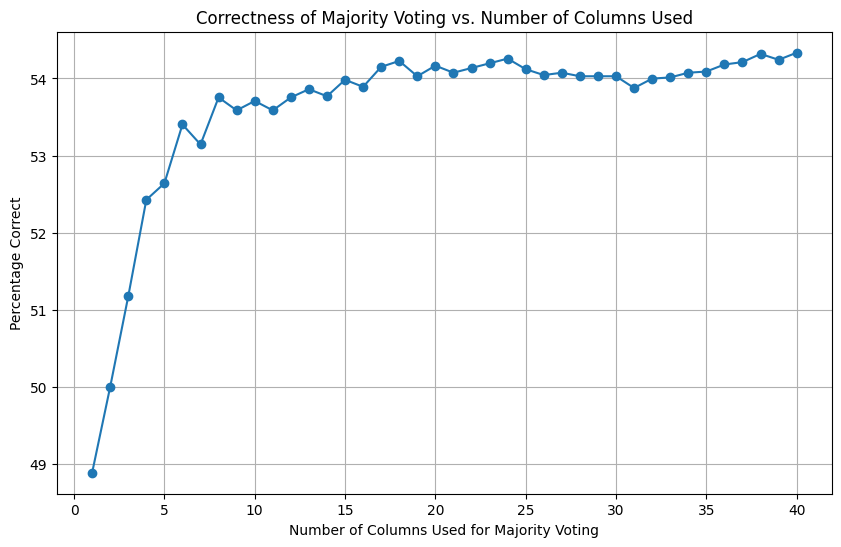

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sample DataFrame setup
# Assume `df` is your DataFrame

# Function to perform majority voting and compare with the correct answer
def majority_voting(df, max_columns):
    results = []
    for num_columns in range(1, max_columns + 1):
        # Selecting the columns
        cols = [f"Final Answer_{i}" for i in range(num_columns)]
        # Majority vote calculation
        df['Majority Vote'] = df[cols].mode(axis=1)[0]
        # Calculating correctness
        correctness = np.mean(df['Majority Vote'] == df['Correct Answer']) * 100
        results.append(correctness)
    
    return results

# Assuming there are 40 answer columns
correctness_results = majority_voting(df_raw, 40)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 41), correctness_results, marker='o')
plt.title('Correctness of Majority Voting vs. Number of Columns Used')
plt.xlabel('Number of Columns Used for Majority Voting')
plt.ylabel('Percentage Correct')
plt.grid(True)
plt.show()


In [36]:
from nltk.tokenize import word_tokenize

def count_tokens(text):
    tokens = word_tokenize(text)
    return len(tokens)

# Assuming your DataFrame is named 'df'
cot_columns = [f'CoT_{i}' for i in range(40)]

# Apply the count_tokens function to each cell in the specified columns
df_raw[cot_columns] = df_raw[cot_columns].applymap(lambda x: count_tokens(str(x)))

# Calculate the average number of tokens for each column
average_tokens = df_raw[cot_columns].mean()

print("Average number of tokens for each column:")
print(average_tokens)

/var/folders/bm/2x1k2y0s2bv2xxbw4jxfs_hh0000gn/T/ipykernel_17535/3693164930.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_raw[cot_columns] = df_raw[cot_columns].applymap(lambda x: count_tokens(str(x)))


LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/PY3/english.pickle[0m

  Searched in:
    - '/Users/guangyawan/nltk_data'
    - '/Users/guangyawan/miniconda3/envs/env/nltk_data'
    - '/Users/guangyawan/miniconda3/envs/env/share/nltk_data'
    - '/Users/guangyawan/miniconda3/envs/env/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************


In [37]:
average_tokens.mean()

NameError: name 'average_tokens' is not defined

In [38]:
def calculate_api_cost(steps):
    tokens_per_step = 141  # Assuming each step consumes 10 tokens on average
    tokens_per_dollar = (1000000/0.75)  # Assuming 1000 tokens per dollar
    total_tokens = steps * tokens_per_step
    api_cost = total_tokens / tokens_per_dollar
    return api_cost

def calculate_time(steps):
    seconds_per_step = 5  # Assuming each step takes 0.5 seconds on average
    total_seconds = steps * seconds_per_step
    return total_seconds

# Calculate API cost and time for each row
metrics_df['API Cost'] = metrics_df['Cost'].apply(calculate_api_cost)
metrics_df['Time (Seconds)'] = metrics_df['Cost'].apply(calculate_time)

metrics_df

,Model,Cost,Accuracy,Category,API Cost,Time (Seconds)
0,claude-3-haiku-20240307,6.067778,0.548889,CASC,0.000642,30.338889
1,claude-3-haiku-20240307,40.000000,0.551111,SC,0.004230,200.000000
2,claude-3-haiku-20240307,14.057778,0.548889,ES,0.001487,70.288889
3,claude-3-haiku-20240307,12.092222,0.555556,ASC,0.001279,60.461111


In [21]:
# df = df_max_cs_acc_with_step_constraints
# df = df_min_cs_accuracy_greater_than_sc
df = df_result

# Additional plots (Appendix)

In [24]:
df = df.rename(columns={'ES_steps':'ESC_steps','CS_steps':'RASC_steps','CS_correctness':'RASC_correctness','ES_correctness':'ESC_correctness',"asc_steps":"ASC_steps","asc_correctness":"ASC_correctness"})

/var/folders/bm/2x1k2y0s2bv2xxbw4jxfs_hh0000gn/T/ipykernel_17535/3114067944.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Name', y='value', hue='Metric', data=correctness_data, ci=None)


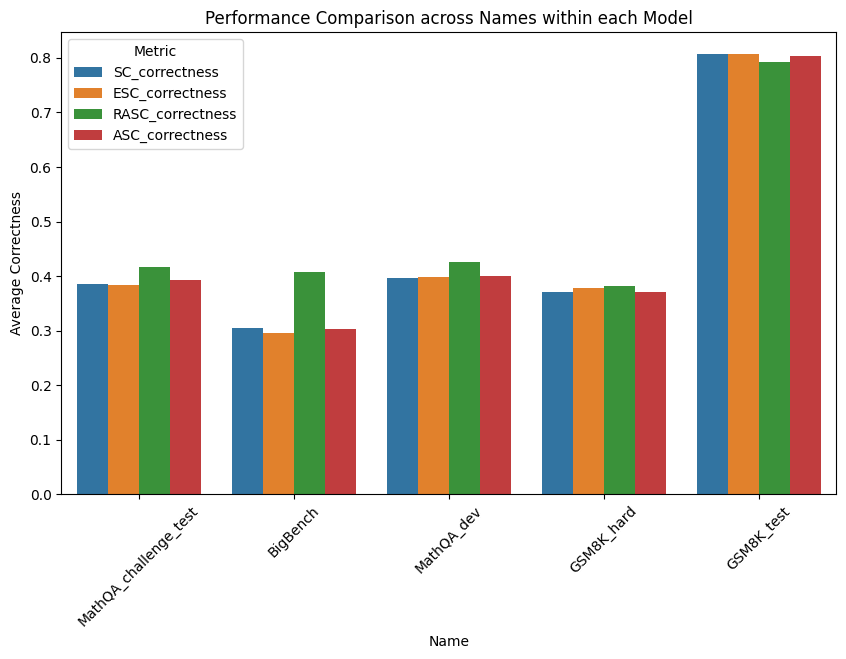

/var/folders/bm/2x1k2y0s2bv2xxbw4jxfs_hh0000gn/T/ipykernel_17535/3114067944.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Model', y='value', hue='Metric', data=correctness_data, ci=None)


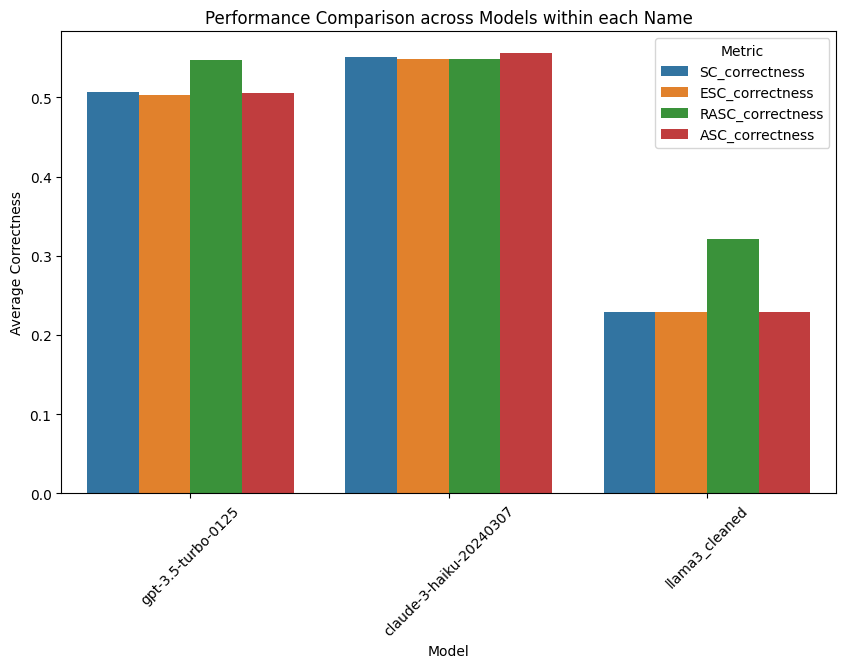

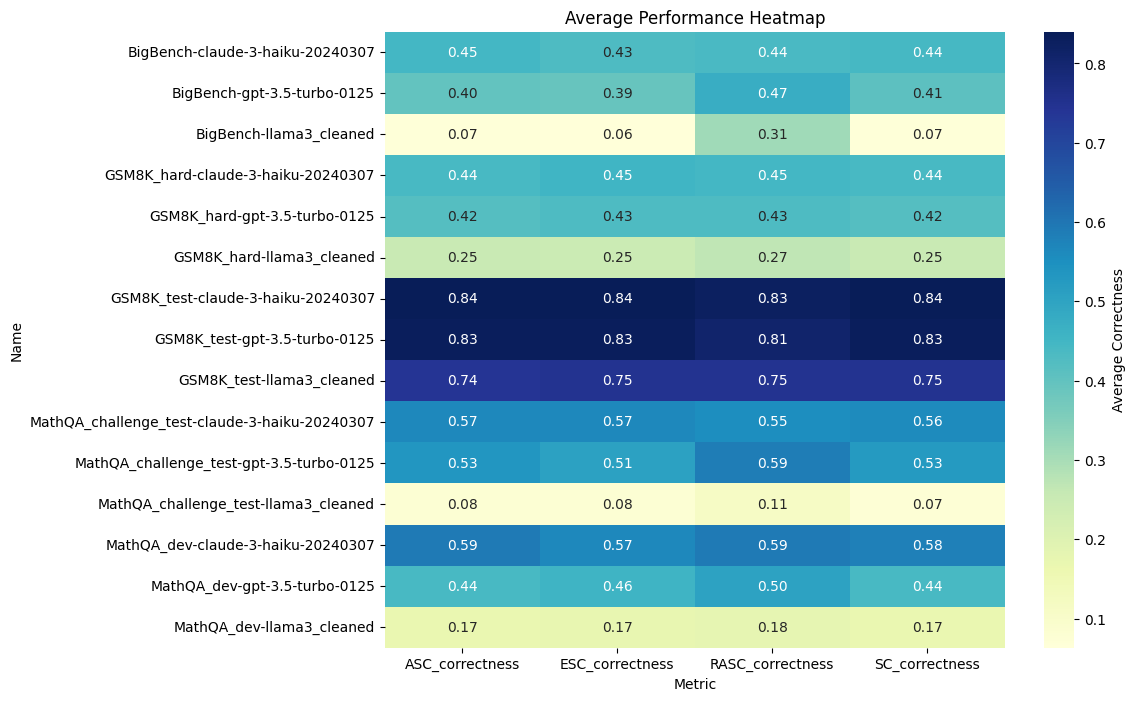

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame that includes 'asc_correctness' and 'asc_steps'

# Melt the DataFrame to convert it into a long format suitable for plotting
# Include 'asc_correctness' and 'asc_steps' in value_vars
melted_df = pd.melt(df, id_vars=['Name', 'Model'], value_vars=['SC_correctness', 'ESC_correctness', 'RASC_correctness', 'ASC_correctness', 'ASC_steps'], var_name='Metric')

# Plot 1: Compare average performance across different Names within each Model for correctness metrics
plt.figure(figsize=(10, 6))
# Filter melted_df to exclude 'asc_steps' for correctness comparison
correctness_data = melted_df[melted_df['Metric'] != 'ASC_steps']
sns.barplot(x='Name', y='value', hue='Metric', data=correctness_data, ci=None)
plt.title('Performance Comparison across Names within each Model')
plt.xlabel('Name')
plt.ylabel('Average Correctness')
plt.legend(title='Metric')
plt.xticks(rotation=45)
plt.show()

# Plot 2: Compare average performance across different Models within each Name for correctness metrics
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='value', hue='Metric', data=correctness_data, ci=None)
plt.title('Performance Comparison across Models within each Name')
plt.xlabel('Model')
plt.ylabel('Average Correctness')
plt.legend(title='Metric')
plt.xticks(rotation=45)
plt.show()

# Plot 3: Heatmap to visualize the average performance for each combination of Name and Model for correctness metrics
heatmap_data = correctness_data.groupby(['Name', 'Model', 'Metric'])['value'].mean().unstack(level=-1)
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.2f', cbar_kws={'label': 'Average Correctness'})
plt.title('Average Performance Heatmap')
plt.xlabel('Metric')
plt.ylabel('Name')
plt.show()

/var/folders/bm/2x1k2y0s2bv2xxbw4jxfs_hh0000gn/T/ipykernel_17535/4154816154.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Name', y='value', hue='Metric', data=melted_df, ci=None)


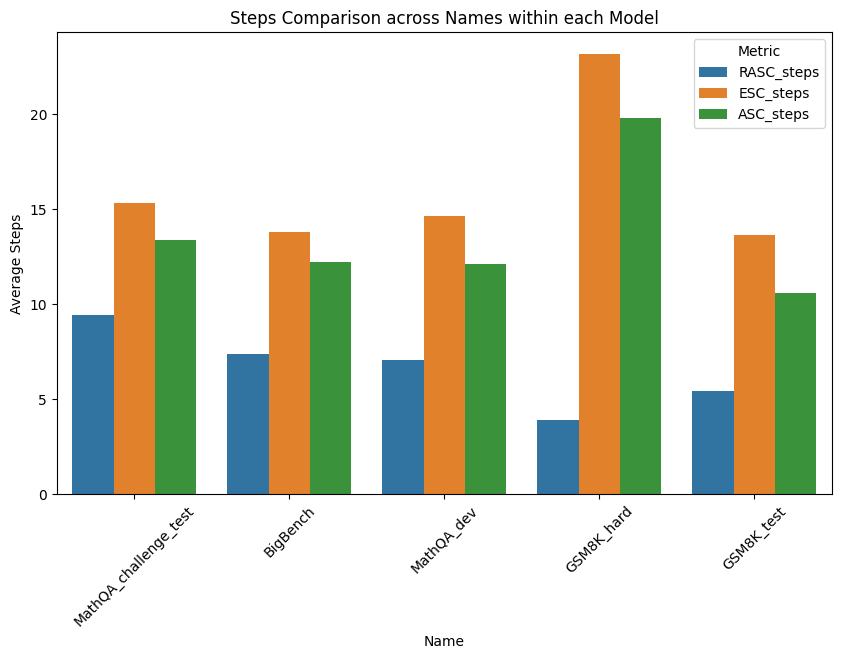

/var/folders/bm/2x1k2y0s2bv2xxbw4jxfs_hh0000gn/T/ipykernel_17535/4154816154.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Model', y='value', hue='Metric', data=melted_df, ci=None)


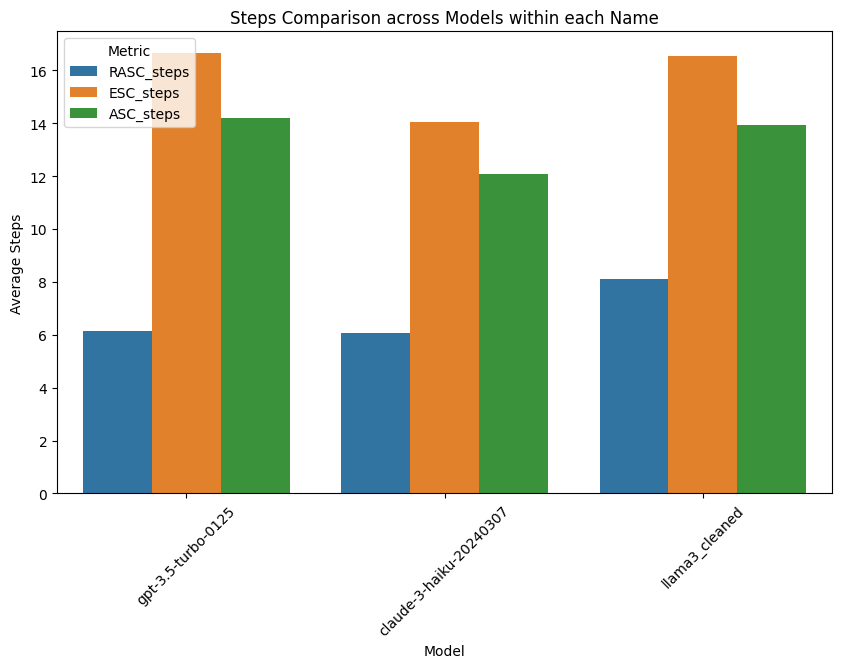

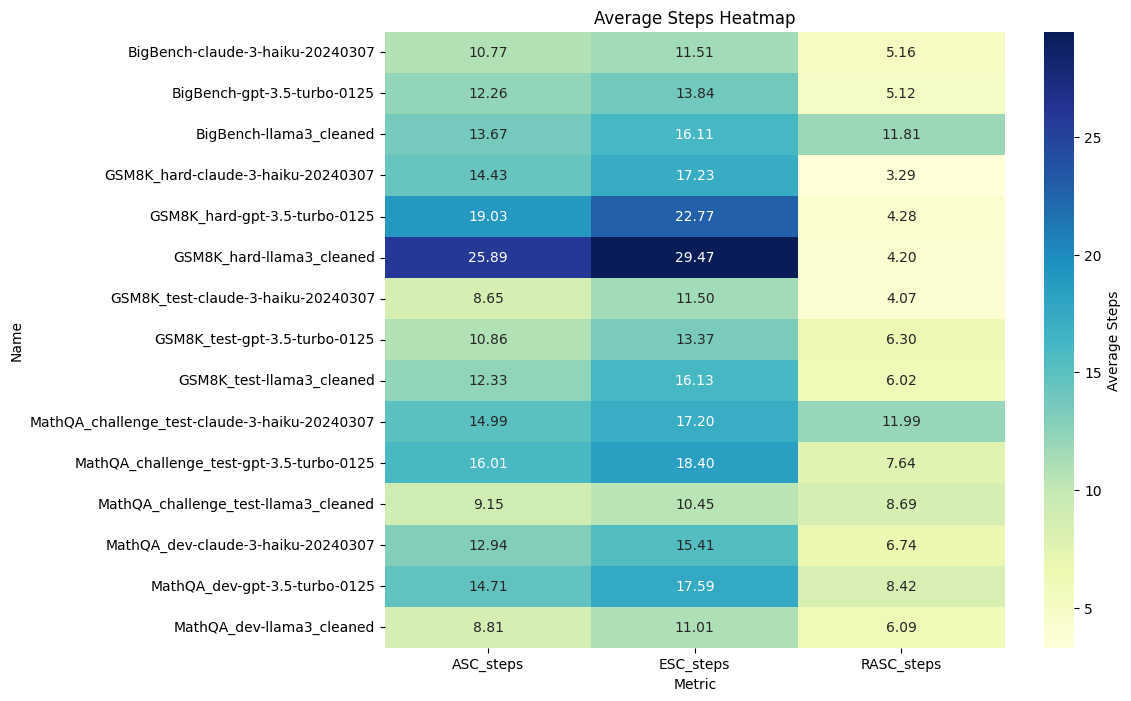

In [27]:
melted_df = pd.melt(df, id_vars=['Name', 'Model'], value_vars=['RASC_steps', 'ESC_steps', 'ASC_steps'], var_name='Metric')

# Plot 1: Compare average steps across different Names within each Model
plt.figure(figsize=(10, 6))
sns.barplot(x='Name', y='value', hue='Metric', data=melted_df, ci=None)
plt.title('Steps Comparison across Names within each Model')
plt.xlabel('Name')
plt.ylabel('Average Steps')
plt.legend(title='Metric')
plt.xticks(rotation=45)
plt.show()

# Plot 2: Compare average steps across different Models within each Name
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='value', hue='Metric', data=melted_df, ci=None)
plt.title('Steps Comparison across Models within each Name')
plt.xlabel('Model')
plt.ylabel('Average Steps')
plt.legend(title='Metric')
plt.xticks(rotation=45)
plt.show()

# Plot 3: Heatmap to visualize the average steps for each combination of Name and Model
heatmap_data = melted_df.groupby(['Name', 'Model', 'Metric'])['value'].mean().unstack(level=-1)
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.2f', cbar_kws={'label': 'Average Steps'})
plt.title('Average Steps Heatmap')
plt.xlabel('Metric')
plt.ylabel('Name')
plt.show()

# Ablation Study 1 (tradeoff between acc and step_reduction with different N and threshold)

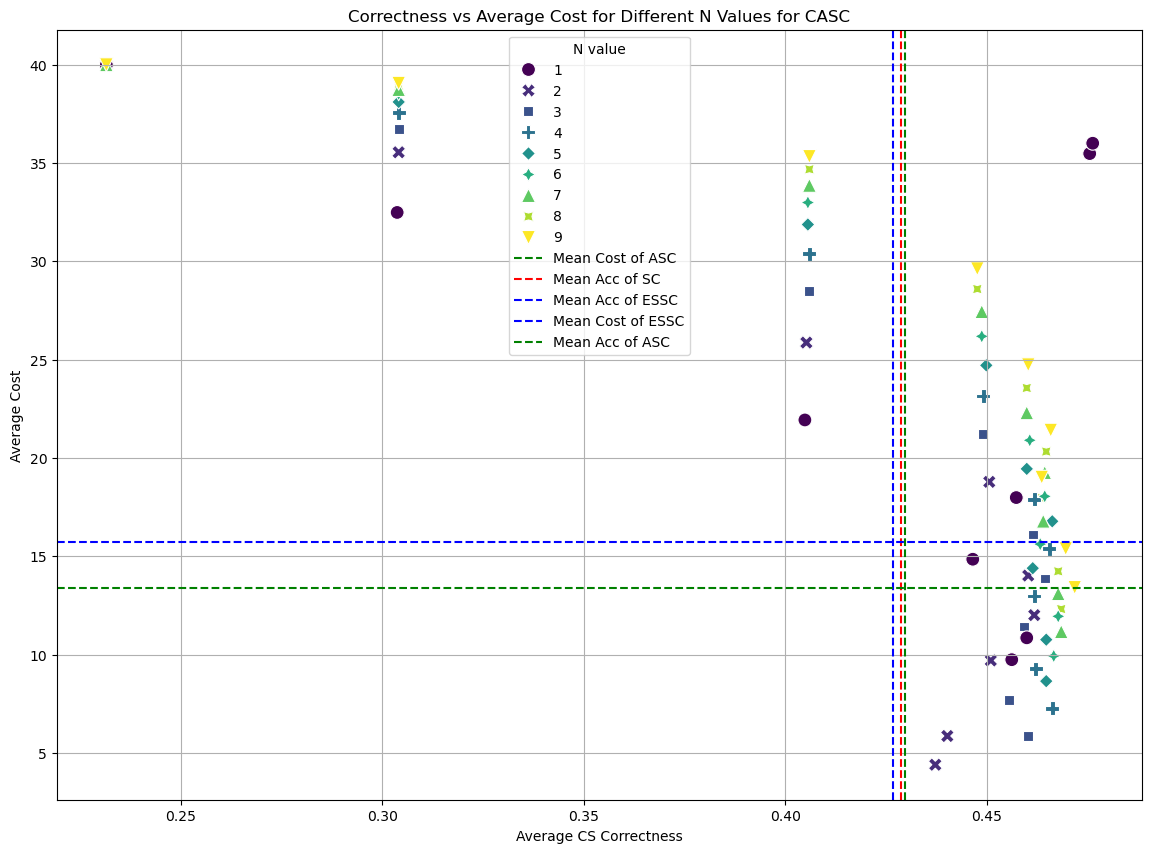

In [67]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Directory containing the CSV files
directory = "../../result/experiments_output/test_N_threshold"


# Initialize an empty list to store DataFrames
dataframes = []

# Dictionary to hold aggregated data
aggregated_data = {}

# List all files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        # Extract the threshold value and stop mechanism from the filename
        threshold_value = float(filename.split('_threshold_')[1].split('_')[0])
        
        # Check if the threshold is 0.5 and the stop mechanism is "PositiveN"
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        
        # Extract the N value from the filename
        n_value = int(filename.split('_N_')[1].split('.')[0])
        if(n_value > 9):
            continue
        
        # Calculate average correctness and steps
        avg_correctness = df['CS_correctness'].mean()
        avg_steps = df['CS_steps'].mean()
        
        # Check if this N value is already in the dictionary
        if n_value not in aggregated_data:
            aggregated_data[n_value] = {'correctness': [], 'steps': []}
        
        # Append the data
        aggregated_data[n_value]['correctness'].append(avg_correctness)
        aggregated_data[n_value]['steps'].append(avg_steps)

# Prepare data for plotting
plot_data = {
    'N_value': [],
    'Average_Correctness': [],
    'Average_Steps': []
}

for n, values in aggregated_data.items():
    plot_data['N_value'].extend([n] * len(values['correctness']))
    plot_data['Average_Correctness'].extend(values['correctness'])
    plot_data['Average_Steps'].extend(values['steps'])

# Convert to DataFrame
plot_df = pd.DataFrame(plot_data)

# Plotting
# Plotting
plt.figure(figsize=(14, 10))
sns.scatterplot(data=plot_df, x='Average_Correctness', y='Average_Steps', hue='N_value', style='N_value', palette='viridis', s=100, legend="full")
plt.title('Correctness vs Average Cost for Different N Values for CASC')
plt.xlabel('Average CS Correctness')
plt.ylabel('Average Cost')

# Add vertical line for base accuracy
plt.axvline(x=df.SC_correctness.sum()/ len(df), color='red', linestyle='--', linewidth=1.5, label='Mean Acc of SC')
plt.axvline(x=df.ES_correctness.sum() / len(df), color='blue', linestyle='--', linewidth=1.5, label='Mean Acc of ESSC')
plt.axvline(x=df.asc_correctness.sum() / len(df), color='green', linestyle='--', linewidth=1.5, label='Mean Acc of ASC')

plt.axhline(y=df.ES_steps.mean(), color='blue', linestyle='--', linewidth=1.5, label='Mean Cost of ESSC')
plt.axhline(y=df.asc_steps.mean(), color='green', linestyle='--', linewidth=1.5, label='Mean Cost of ASC')

# Modify legend to display one entry per N value
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = list(set(labels))
# Sort the unique labels based on their corresponding N values
sorted_labels = sorted(unique_labels, key=lambda x: int(x) if x.isdigit() else float('inf'))

# Get the corresponding handles for the sorted labels
sorted_handles = [handles[labels.index(label)] for label in sorted_labels]

plt.legend(sorted_handles, sorted_labels, title='N value')


plt.grid(True)
plt.show()

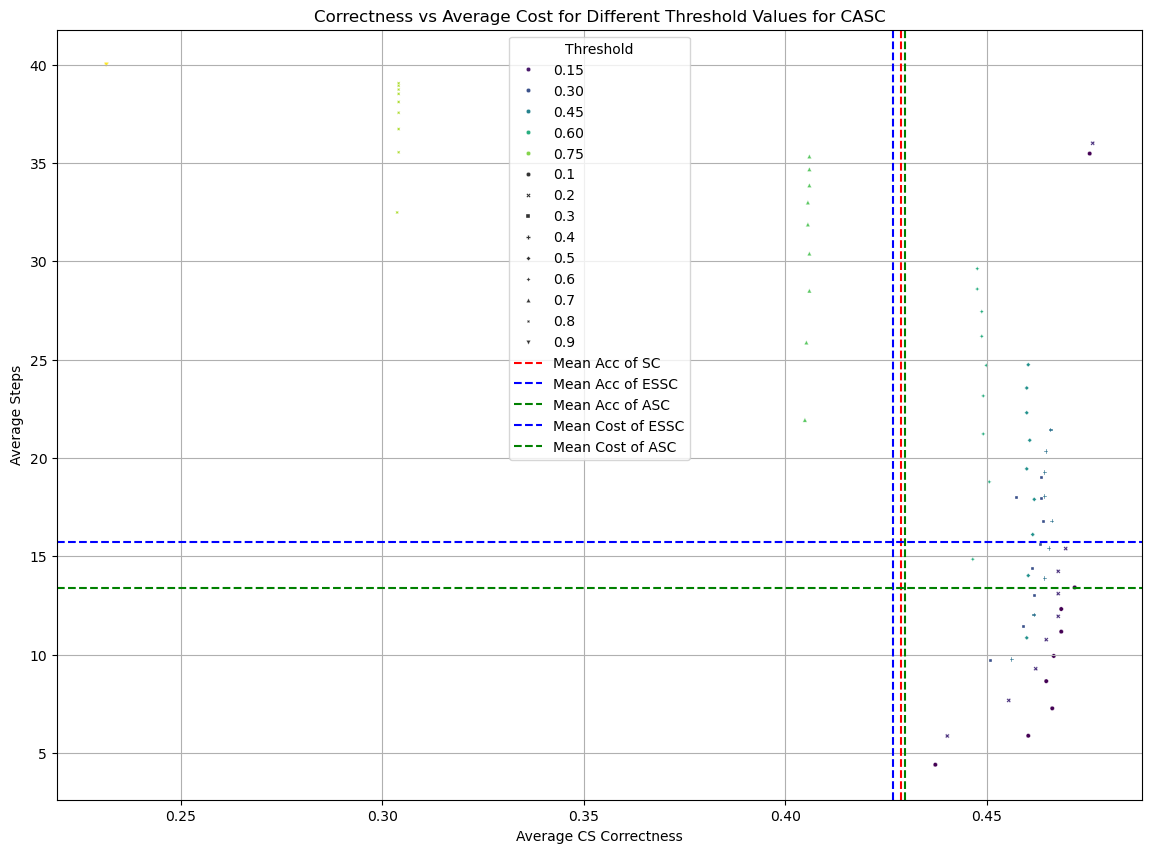

In [38]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Initialize an empty list to store DataFrames
dataframes = []

# Dictionary to hold aggregated data
aggregated_data = {}

# List all files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        
        # Extract the threshold value from the filename
        threshold_value = float(filename.split('_threshold_')[1].split('_')[0])
                # Extract the N value from the filename
        n_value = int(filename.split('_N_')[1].split('.')[0])
        if(n_value > 9):
            continue
        # Calculate average correctness and steps
        avg_correctness = df['CS_correctness'].mean()
        avg_steps = df['CS_steps'].mean()
        
        # Check if this threshold value is already in the dictionary
        if threshold_value not in aggregated_data:
            aggregated_data[threshold_value] = {'correctness': [], 'steps': []}
        
        # Append the data
        aggregated_data[threshold_value]['correctness'].append(avg_correctness)
        aggregated_data[threshold_value]['steps'].append(avg_steps)

# Prepare data for plotting
plot_data = {
    'Threshold': [],
    'Average_Correctness': [],
    'Average_Steps': []
}

for threshold, values in aggregated_data.items():
    plot_data['Threshold'].extend([threshold] * len(values['correctness']))
    plot_data['Average_Correctness'].extend(values['correctness'])
    plot_data['Average_Steps'].extend(values['steps'])

# Convert to DataFrame
plot_df = pd.DataFrame(plot_data)





In [43]:
plot_df['idx'] = plot_df['Threshold'].sort_values()

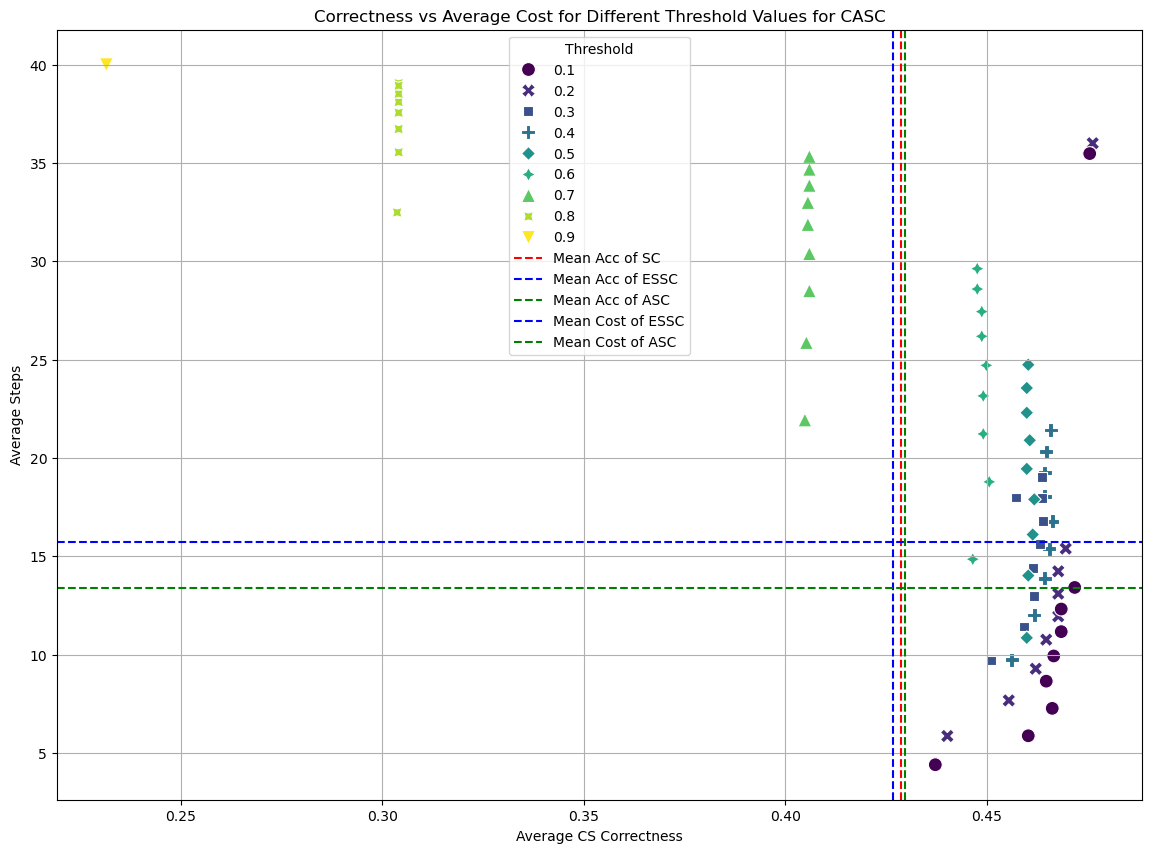

In [53]:
# Plotting
plt.figure(figsize=(14, 10))
sns.scatterplot(data=plot_df, x='Average_Correctness', y='Average_Steps', style='Threshold', hue='Threshold', palette='viridis', s=100, legend="full")
plt.title('Correctness vs Average Cost for Different Threshold Values for CASC')
plt.xlabel('Average CS Correctness')
plt.ylabel('Average Steps')
# Add vertical line for base accuracy
# Add vertical line for base accuracy
plt.axvline(x=df.SC_correctness.sum()/ len(df), color='red', linestyle='--', linewidth=1.5, label='Mean Acc of SC')
plt.axvline(x=df.ES_correctness.sum() / len(df), color='blue', linestyle='--', linewidth=1.5, label='Mean Acc of ESSC')
plt.axvline(x=df.asc_correctness.sum() / len(df), color='green', linestyle='--', linewidth=1.5, label='Mean Acc of ASC')

plt.axhline(y=df.ES_steps.mean(), color='blue', linestyle='--', linewidth=1.5, label='Mean Cost of ESSC')
plt.axhline(y=df.asc_steps.mean(), color='green', linestyle='--', linewidth=1.5, label='Mean Cost of ASC')


plt.legend(title='Threshold')

plt.grid(True)
plt.show()


In [29]:
threshold_labels

{'0.6': 'Threshold: 0.6',
 '0.9': 'Threshold: 0.9',
 '0.2': 'Threshold: 0.2',
 '0.4': 'Threshold: 0.4',
 '0.8': 'Threshold: 0.8',
 '0.1': 'Threshold: 0.1',
 '0.7': 'Threshold: 0.7',
 '0.3': 'Threshold: 0.3',
 '0.5': 'Threshold: 0.5'}

([], [])

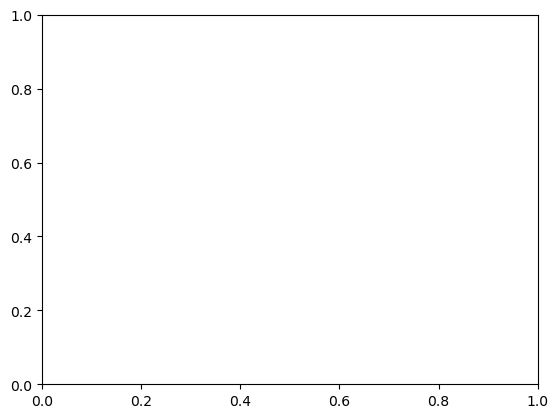

In [28]:
plt.gca().get_legend_handles_labels()

In [27]:
plot_df['Threshold'].unique()

array([0.6, 0.9, 0.2, 0.4, 0.8, 0.1, 0.7, 0.3, 0.5])

In [20]:
plot_df.Threshold.value_counts()

Threshold
0.6    9
0.9    9
0.2    9
0.4    9
0.8    9
0.1    9
0.7    9
0.3    9
0.5    9
Name: count, dtype: int64

In [17]:
plot_df

,Threshold,Average_Correctness,Average_Steps
0,0.6,0.447584,28.592193
1,0.6,0.448699,26.187361
2,0.6,0.446468,14.850929
3,0.6,0.450558,18.785874
4,0.6,0.449071,23.156506
...,...,...,...
76,0.5,0.461338,16.107063
77,0.5,0.460223,14.020074
78,0.5,0.459851,19.447212
79,0.5,0.459851,22.299628
